In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve, auc
from sklearn.model_selection import train_test_split



from get_dataset import X_train_tensor as X_train, X_test_tensor as X_test, y_train_tensor as y_train, y_test_tensor as y_test

Dataset preview:
   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no  

Dataset shape: (45211, 17)

Categorical columns: ['job', 'marital', 'education', 'default', '

In [7]:

# from get_dataset import X
# from get_dataset import y

# X_np = X.values if hasattr(X, 'values') else X
# y_np = y.values if hasattr(y, 'values') else y

# # Split data
# X_train, X_test, y_train, y_test = train_test_split(X_np, y_np, test_size=0.2, random_state=42, stratify=y_np)

# # Scale features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Convert to PyTorch tensors
# X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train = torch.FloatTensor(y_train)
# X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test = torch.FloatTensor(y_test)

# Create dataset and dataloader
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(dataset=train_dataset, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, shuffle=False)


In [8]:

# Define the logistic regression model
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
        
    def forward(self, x):
        return torch.sigmoid(self.linear(x))


In [9]:

# Instantiate the model
input_dim = X_train.shape[1]
model = LogisticRegressionModel(input_dim)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.01)  # L2 regularization

# Lists to store metrics for plotting
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [10]:

# Training function
def train_model(model, train_loader, criterion, optimizer, epochs=100):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Track statistics
            running_loss += loss.item() * inputs.size(0)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        # Validation
        model.eval()
        val_loss, val_acc = evaluate_model(model, test_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        # Print statistics every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, '
                  f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, '
                  f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')


In [11]:

# Evaluation function
def evaluate_model(model, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return running_loss / len(data_loader.dataset), correct / total

# Function to get predictions
def get_predictions(model, data_loader):
    model.eval()
    y_true = []
    y_pred = []
    y_prob = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs).squeeze()
            predicted = (outputs > 0.5).float()
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_prob.extend(outputs.cpu().numpy())
    
    return np.array(y_true), np.array(y_pred), np.array(y_prob)

# Train the model
num_epochs = 100
train_model(model, train_loader, criterion, optimizer, epochs=num_epochs)

# Get predictions
y_true, y_pred, y_prob = get_predictions(model, test_loader)

# Calculate metrics
accuracy = np.mean(y_true == y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)
class_report = classification_report(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_prob)

# Print results
print(f"Model accuracy: {accuracy:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

# Get model coefficients and intercept
with torch.no_grad():
    coefficients = model.linear.weight.data.cpu().numpy()[0]
    intercept = model.linear.bias.data.cpu().numpy()[0]

print("\nModel Coefficients:")
if hasattr(X, 'columns'):
    for feature, coef_value in zip(X.columns, coefficients):
        print(f"{feature}: {coef_value:.6f}")
else:
    print(coefficients)
print(f"Intercept: {intercept:.6f}")

# Plot training and validation curves
# def plot_learning_curves():
#     plt.figure(figsize=(12, 5))
    
#     # Plot training & validation loss
#     plt.subplot(1, 2, 1)
#     plt.plot(train_losses, label='Training Loss')
#     plt.plot(val_losses, label='Validation Loss')
#     plt.title('Loss Curves')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()
#     plt.grid(True)
    
#     # Plot training & validation accuracy
#     plt.subplot(1, 2, 2)
#     plt.plot(train_accuracies, label='Training Accuracy')
#     plt.plot(val_accuracies, label='Validation Accuracy')
#     plt.title('Accuracy Curves')
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy')
#     plt.legend()
#     plt.grid(True)
    
#     plt.tight_layout()
#     plt.show()

    

ValueError: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([])) is deprecated. Please ensure they have the same size.

In [12]:


def plot_learning_curves():
    plt.style.use('seaborn-v0_8-dark')

    fig, ax = plt.subplots(1, 2, figsize=(16, 4.5))
    
    # Plot training & validation loss
    ax[0].plot(train_losses, label='Training Loss')
    ax[0].plot(val_losses, label='Validation Loss')
    ax[0].set(title="Loss over epochs", xlabel='Epochs', ylabel='Loss')
    
    # Plot training & validation accuracy
    ax[1].plot(train_accuracies, label='Training Accuracy')
    ax[1].plot(val_accuracies, label='Validation Accuracy')
    ax[1].set(title="Accuracy over epochs", xlabel='Epochs', ylabel='Accuracy')
    
    # Add legends
    ax[0].legend()
    ax[1].legend()
    
    # Show the plot
    plt.tight_layout()
    plt.show()

    # Change the plot style back to default
    plt.style.use('default')

# Plot ROC curve
def plot_roc_curve():
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# Plot Precision-Recall curve
def plot_precision_recall_curve():
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall, precision)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (area = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Plot convergence with increasing epochs

def plot_convergence_with_epochs():
    # Create temporary model and optimizer for epoch tests
    models_at_epochs = []
    epochs_to_test = [10, 20, 30, 40, 50, 75, 100]
    
    # Train models with different epoch counts
    for epoch_count in epochs_to_test:
        temp_model = LogisticRegressionModel(input_dim)
        temp_optimizer = optim.SGD(temp_model.parameters(), lr=0.01, weight_decay=0.01)
        
        # Train for specified number of epochs
        for epoch in range(epoch_count):
            temp_model.train()
            for inputs, labels in train_loader:
                temp_optimizer.zero_grad()
                outputs = temp_model(inputs).squeeze()
                loss = criterion(outputs, labels)
                loss.backward()
                temp_optimizer.step()
        
        # Store the model
        models_at_epochs.append(temp_model)
    
    # Evaluate models
    train_accs = []
    val_accs = []
    
    for temp_model in models_at_epochs:
        # Get training accuracy
        _, train_acc = evaluate_model(temp_model, train_loader, criterion)
        train_accs.append(train_acc)
        
        # Get validation accuracy
        _, val_acc = evaluate_model(temp_model, test_loader, criterion)
        val_accs.append(val_acc)
    
    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(epochs_to_test, train_accs, 'o-', color='blue', label='Training accuracy')
    plt.plot(epochs_to_test, val_accs, 'o-', color='green', label='Validation accuracy')
    plt.title('Convergence Check: Model Accuracy vs Epochs', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend(loc='best', fontsize=12)
    plt.grid(True)
    plt.show()
    
    

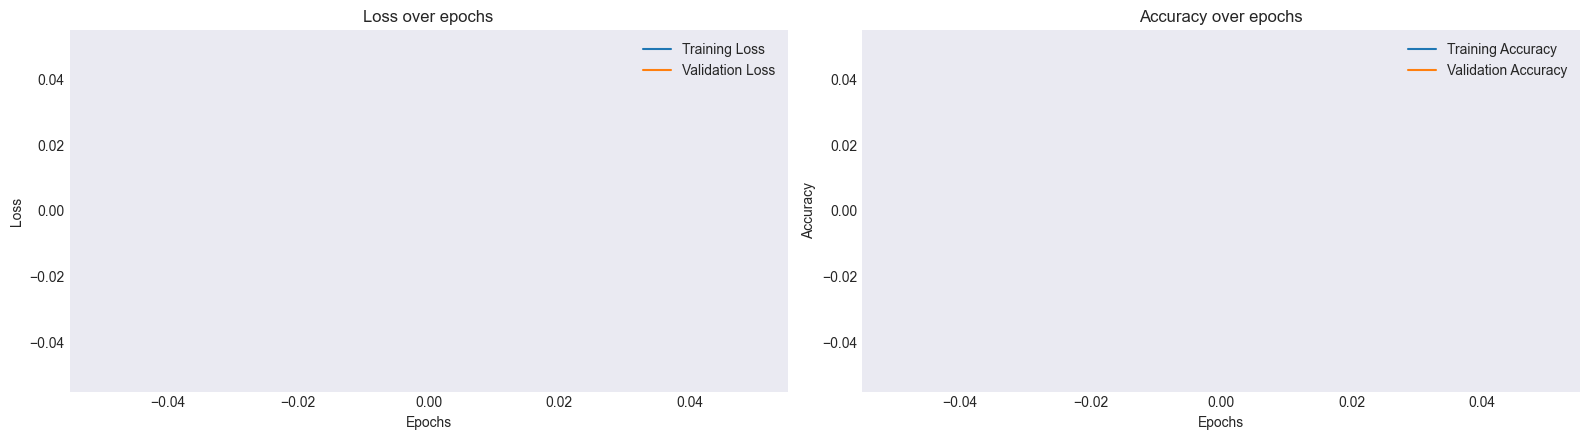

In [13]:

# Call plotting functions
plot_learning_curves()


In [ ]:
plot_roc_curve()


In [ ]:
plot_precision_recall_curve()


In [ ]:
plot_convergence_with_epochs()